In [1]:
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [2]:
# 라이브러리 가져오기
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, re
import seaborn as sns

from wordcloud import wordcloud
%matplotlib inline

C:\Users\alstn\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 데이터 불러오기

In [3]:
train_data = pd.read_csv('train.csv', header=0)
x_test = pd.read_csv('test.csv', header=0)
y_test = pd.read_csv('sample_submission.csv', header=0)

#### 상품 평점 예측

In [4]:
train_data.shape, x_test.shape, y_test.shape

((25000, 3), (25000, 2), (25000, 2))

In [5]:
train_data.head(4)

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2


In [6]:
x_test.head(1)

,id,reviews
0,0,채소가 약간 시들어 있어요


In [7]:
y_test.head(1)

,id,target
0,0,0


# 텍스트 분포 확인

In [8]:
train_len = train_data['reviews'].astype(str).apply(len)

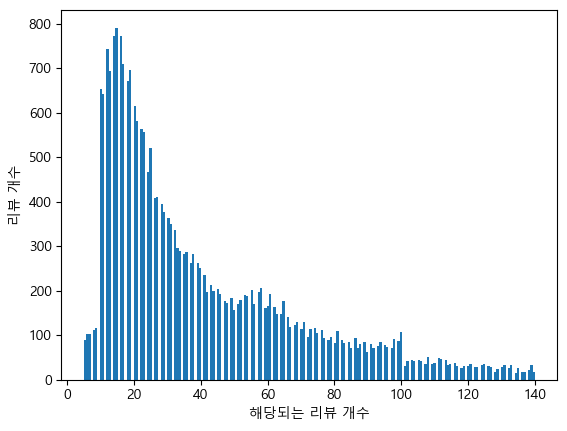

In [9]:
plt.hist(train_len, bins=200)
plt.ylabel('리뷰 개수')
plt.xlabel('해당되는 리뷰 개수')
plt.show()

# 단어의 수로 분포확인

In [10]:
train_word = train_data['reviews'].apply(lambda x :len(x.split(' ')))

In [11]:
train_word.describe()

count    25000.000000
mean         8.620000
std          6.619492
min          1.000000
25%          4.000000
50%          6.000000
75%         12.000000
max         45.000000
Name: reviews, dtype: float64

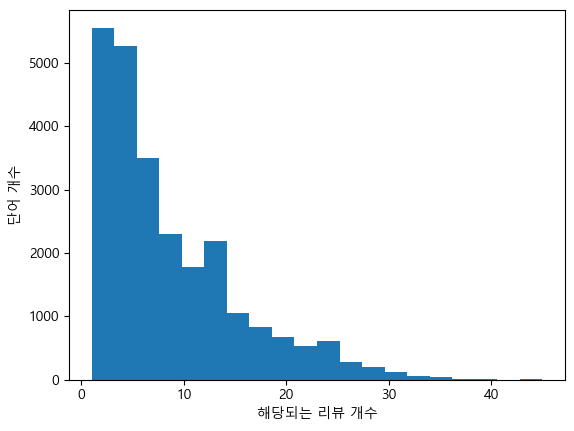

In [12]:
plt.hist(train_word, bins=20)
plt.ylabel('단어 개수')
plt.xlabel('해당되는 리뷰 개수')
plt.show()

# 평점 분포

In [13]:
train_data['target'].value_counts()

5    10000
2     8000
1     4500
4     2500
Name: target, dtype: int64

In [14]:
train_value = train_data['target'].value_counts()

Text(0.5, 1.0, '평점 분포')

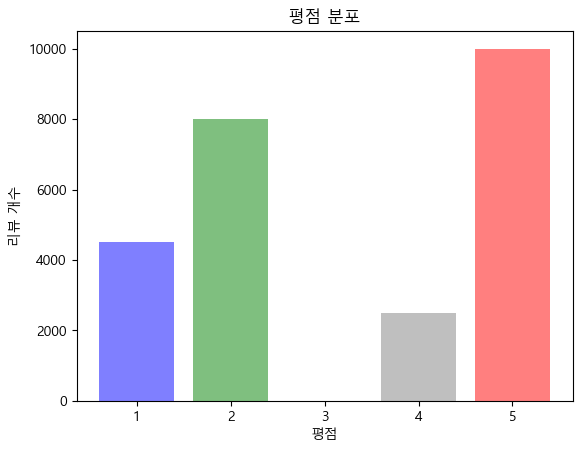

In [15]:
x = train_value.index
y = train_value.values

plt.bar(x, y, color=['r', 'g', 'b', 'gray'], alpha=0.5)
plt.xlabel('평점')
plt.ylabel('리뷰 개수')
plt.title('평점 분포')

# 데이터 전처리

In [16]:
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm

In [17]:
train_reviews = [review for review in train_data['reviews'] if type(review) is str]

In [18]:
train_reviews[:3], len(train_reviews)

(['조아요 처음구입 싸게햇어요',
  '생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 아깝네요',
  '디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져있네요 ㅠ 귀찮아서 그냥쓰려구요 배송기사님은 친절하셨어요'],
 25000)

### 정규표현식을 이용한 한글 이외 처리

In [19]:
train_data['reviews'][16]

'재구매 별로별로별로별로 불량품 교환이나 환불 미흡 고객센터 개인 휴대폰번호 이제 다른곳으로 주문,,, 별로별로'

In [20]:
re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', '', train_data['reviews'][16])

'재구매 별로별로별로별로 불량품 교환이나 환불 미흡 고객센터 개인 휴대폰번호 이제 다른곳으로 주문 별로별로'

In [21]:
train_data['reviews'] = train_data['reviews'].astype(str).apply(lambda x : re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', '', x))

# 형태소 분석

In [22]:
okt = Okt()

In [23]:
train_data['reviews'][16]

'재구매 별로별로별로별로 불량품 교환이나 환불 미흡 고객센터 개인 휴대폰번호 이제 다른곳으로 주문 별로별로'

In [24]:
okt.morphs(train_data['reviews'][16], stem=True)

['재다',
 '별로',
 '별로',
 '별로',
 '별로',
 '불량품',
 '교환',
 '이나',
 '환불',
 '미흡',
 '고객',
 '센터',
 '개인',
 '휴대폰번호',
 '이제',
 '다른',
 '곳',
 '으로',
 '주문',
 '별로',
 '별로']

In [25]:
print("품사 태깅 결과:", okt.pos(train_data['reviews'][16]))

품사 태깅 결과: [('재구매', 'Verb'), ('별로', 'Noun'), ('별로', 'Noun'), ('별로', 'Noun'), ('별로', 'Noun'), ('불량품', 'Noun'), ('교환', 'Noun'), ('이나', 'Josa'), ('환불', 'Noun'), ('미흡', 'Noun'), ('고객', 'Noun'), ('센터', 'Noun'), ('개인', 'Noun'), ('휴대폰번호', 'Noun'), ('이제', 'Noun'), ('다른', 'Modifier'), ('곳', 'Noun'), ('으로', 'Josa'), ('주문', 'Noun'), ('별로', 'Noun'), ('별로', 'Noun')]


In [26]:
print("명사 추출 결과:", okt.nouns(train_data['reviews'][16]))

명사 추출 결과: ['별로', '별로', '별로', '별로', '불량품', '교환', '환불', '미흡', '고객', '센터', '개인', '휴대폰번호', '이제', '곳', '주문', '별로', '별로']


In [27]:
from konlpy.tag import Okt

# Okt 객체 생성
okt = Okt()

# 형태소 분석 및 원형 추출
text = "어제 먹었던게 오늘 먹은거보다 나은데?"
word_review = okt.morphs(text, stem=True)
print(word_review)


['어제', '먹다', '오늘', '먹다', '낫다', '?']


In [28]:
from konlpy.tag import Okt

# Okt 객체 생성
okt = Okt()

# 형태소 분석 및 원형 추출
text = "어제 먹었던게 오늘 먹은거보다 나은데?"
word_review = okt.morphs(text, stem=False)
print(word_review)


['어제', '먹었던게', '오늘', '먹은거보다', '나은데', '?']


# 형태소 단위 분석후 불용어 제거(은는이가)

In [29]:
stop_words = ['은', '는', '이', '가', '하', '아', '것', '들', '의',
              '있', '되', '수', '보', '주', '등', '한']

In [30]:
def preprocessing(text, okt, remove_stopwords=False, stop_words=[]):
    # 1. 형태소 분석
    word_review = okt.morphs(text, stem=True)
    # 2. True인 경우 불용어 제거
    if remove_stopwords and len(stop_words) > 0:
        word_review = [word for word in word_review if word not in stop_words]
    return word_review

#### 제거 과정

#### 너무 오래걸려서 1000개로 축소후 진행

In [31]:
clean_train_reviews = []
for i in range(len(train_data[:1000])):
    clean_train_reviews.append(preprocessing(train_data['reviews'][i], okt, True, stop_words))

In [32]:
clean_train_reviews[16]

['재다',
 '별로',
 '별로',
 '별로',
 '별로',
 '불량품',
 '교환',
 '이나',
 '환불',
 '미흡',
 '고객',
 '센터',
 '개인',
 '휴대폰번호',
 '이제',
 '다른',
 '곳',
 '으로',
 '주문',
 '별로',
 '별로']

# 단어 사전 생성과 임베딩

In [38]:
# 토크나이저 가져오기
tokenizer = Tokenizer()

# 토크나이징을 위한 사전 생성
tokenizer.fit_on_texts(clean_train_reviews)

# 토크나이징-인덱싱 진행
train_sequences = tokenizer.texts_to_sequences(clean_train_reviews)

In [39]:
len(train_sequences)

1000

In [40]:
train_sequences[16]

[12,
 48,
 48,
 48,
 48,
 1326,
 188,
 424,
 834,
 1327,
 835,
 836,
 642,
 1328,
 425,
 55,
 164,
 28,
 35,
 48,
 48]

#### train_label 정의

In [42]:
# 레이블 정의
train_labels = np.array(train_data['target'])

# 패딩
변경점
- 9보다 적은 단어 수를 가진 대상

In [43]:
MAX_SEQUENCE_LENGTH = 9

#### 패딩 작업

In [46]:
train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH,
                             padding='post')

In [47]:
train_inputs[:10]

array([[   2,  132,   69,   73,  312,  253,    9,    0,    0],
       [  13,  204,   47,  823,  500,  128,  634,    5,  313],
       [  86,   74,  176,   31, 1306,    6,  225,  254,  226],
       [  17,  635,   87,  827,   11,   13,   62,  100,    9],
       [ 108,  828,   23,   11, 1314,    0,    0,    0,    0],
       [ 208,  505,    3,   24,    1,  208,    3,   24, 1320],
       [   3,  361,   10,  109,  831,   16,  133,  506,   57],
       [ 107,  637,    2,   17,    0,    0,    0,    0,    0],
       [  83,  177,    3,  639,  138,  149,  315,   52,   20],
       [ 279,  150,    3,   48,   49,    9,    0,    0,    0]])

In [52]:
train_inputs.shape, train_labels[:1000].shape

((1000, 9), (1000,))

In [54]:
from sklearn.model_selection import train_test_split

# 학습 및 평가 데이터 분리
x_train, x_test, y_train, y_test = \
train_test_split(train_inputs, train_labels[:1000], test_size=0.1, random_state=43)

In [55]:
x_train.shape, y_train.shape

((900, 9), (900,))

#### 하이퍼파라미터 설정

In [56]:
VOCAB_SIZE = len(tokenizer.index_word) + 1
EMB_SIZE = 128
BATCH_SIZE = 16
NUM_EPOCHS = 20

# 모델 설계

층의 구조는 동일하게 설정

변경점
- 출력층의 유닛 수와 활성화 함수 변경

In [116]:
import tensorflow as tf

input_x = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,))
# -> (None, 8, 60000)
emb = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(input_x)
# -> (None, 8, 128)
drob_1 = tf.keras.layers.Dropout(0.2)(emb)
# -> (None, 8, 128)
rnn_1 = tf.keras.layers.GRU(units=64, activation='tanh',
                                 return_sequences=True)(drob_1)
drob_2 = tf.keras.layers.Dropout(0.2)(rnn_1)
# -> (None, 8, 64)
rnn_2 = tf.keras.layers.GRU(units=32, activation='tanh',
                                 return_sequences=True)(drob_2)
drob_3 = tf.keras.layers.Dropout(0.2)(rnn_2)
# -> (None, 8, 32)
rnn_3 = tf.keras.layers.GRU(units=16, activation='tanh',
                                 return_sequences=True)(drob_3)
# -> (None, 8, 16)
rnn_4 = tf.keras.layers.GRU(units=8, activation='tanh',
                                 return_sequences=False)(rnn_3)
# -> (None, 8)
drob_4 = tf.keras.layers.Dropout(0.2)(rnn_4)
# -> (None, 8)
output = tf.keras.layers.Dense(units=6, activation='softmax')(drob_4)

# 모델 선언
model = tf.keras.Model(input_x, output)

In [117]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [118]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 9)]               0         
                                                                 
 embedding_4 (Embedding)     (None, 9, 128)            378880    
                                                                 
 dropout_16 (Dropout)        (None, 9, 128)            0         
                                                                 
 gru_16 (GRU)                (None, 9, 64)             37248     
                                                                 
 dropout_17 (Dropout)        (None, 9, 64)             0         
                                                                 
 gru_17 (GRU)                (None, 9, 32)             9408      
                                                                 
 dropout_18 (Dropout)        (None, 9, 32)             0   

### 결과

In [119]:
# 훈련
model.fit(x=train_X, y=train_y,
          batch_size=BATCH_SIZE,
         epochs=NUM_EPOCHS,
         validation_split=0.1)

Epoch 1/20
51/51 [==============================] - 9s 46ms/step - loss: 1.4667 - accuracy: 0.3815 - val_loss: 1.3422 - val_accuracy: 0.4444
Epoch 2/20
51/51 [==============================] - 1s 13ms/step - loss: 1.3154 - accuracy: 0.4160 - val_loss: 1.2907 - val_accuracy: 0.5111
Epoch 3/20
51/51 [==============================] - 1s 13ms/step - loss: 1.1412 - accuracy: 0.5704 - val_loss: 1.2585 - val_accuracy: 0.4222
Epoch 4/20
51/51 [==============================] - 1s 13ms/step - loss: 0.9473 - accuracy: 0.6667 - val_loss: 1.3007 - val_accuracy: 0.4222
Epoch 5/20
51/51 [==============================] - 1s 13ms/step - loss: 0.7487 - accuracy: 0.7926 - val_loss: 1.4155 - val_accuracy: 0.3889
Epoch 6/20
51/51 [==============================] - 1s 12ms/step - loss: 0.5674 - accuracy: 0.8469 - val_loss: 1.6293 - val_accuracy: 0.4222
Epoch 7/20
51/51 [==============================] - 1s 13ms/step - loss: 0.4789 - accuracy: 0.8679 - val_loss: 1.7757 - val_accuracy: 0.3889
Epoch 8/20
51

### 훈련된 모델의 상품평 예측

In [120]:
pred = np.argmax(model.predict(x_test[16].reshape(-1, 9)))
print("16번쨰 인덱스의 상품평 예측 평점: ", pred)

1/1 [==============================] - 1s 1s/step
16번쨰 인덱스의 상품평 예측 평점:  2


In [121]:
print('상품평: ',train_data['reviews'].iloc[16])
print('평점: ',train_data['target'].iloc[16])

상품평:  재구매 별로별로별로별로 불량품 교환이나 환불 미흡 고객센터 개인 휴대폰번호 이제 다른곳으로 주문 별로별로
평점:  2
